In [1]:
from typing import *

import numpy as np
import torch
from torch import Tensor
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats
import seaborn as sns

sns.set_context("paper", font_scale=1.5)
matplotlib.rc("font", family="serif", serif=["CMU Serif"])
matplotlib.rc("text", usetex=True)
# matplotlib.rc("font", family="sans-serif"); matplotlib.rc("text", usetex=False)
matplotlib.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"
matplotlib.font_manager.findfont("CMU Serif", rebuild_if_missing=True)

findfont: Font family ['CMU Serif'] not found. Falling back to DejaVu Sans.


'/nethome/douglaso/work/LLMInference/.venv/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'

In [2]:
def attention_weight(q: Tensor, k: Tensor, mask: Tensor) -> Tensor:
    a = (q @ k.transpose(-1, -2)).mul_(q.shape[-1]**-0.5).add_(mask)
    return torch.nn.functional.softmax(a, dim=-1)

data = torch.load("data/llama7b_x40.pt")
Q, M, K, V = (data[t].float() for t in "qmkv")
A = attention_weight(Q, K, M)
{t: tuple(globals()[t].shape) for t in "QMKVA"}

{'Q': (40, 32, 32, 1, 128),
 'M': (40, 32, 1, 1, 2048),
 'K': (40, 32, 32, 2048, 128),
 'V': (40, 32, 32, 2048, 128),
 'A': (40, 32, 32, 1, 2048)}

# Attention scores are sparse

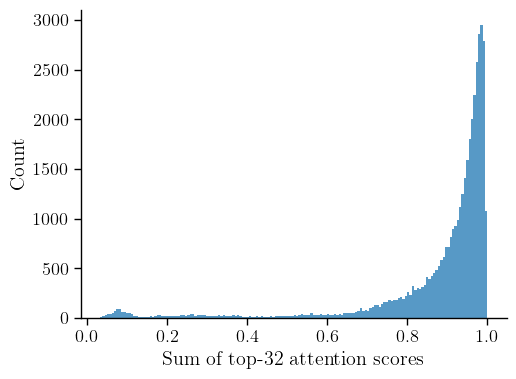

In [3]:
k = 32
topk_metric = torch.topk(A, k=k, dim=-1).values.sum(-1)

plt.figure(figsize=(5.5, 4))
ax = sns.histplot(topk_metric.flatten(), lw=0)
sns.despine(ax=ax)
ax.set_xlabel(f"Sum of top-{k} attention scores")
plt.savefig(f"out/analysis/attention_scores_hist.pdf", bbox_inches="tight")

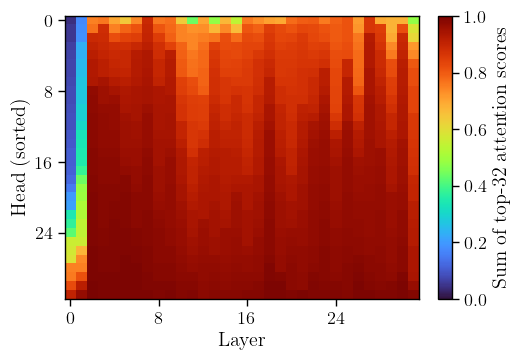

In [4]:
def show_head_heatmap(data: Tensor, norm: matplotlib.colors.Normalize) -> matplotlib.axes.Axes:
    """data -- (layer, head)"""
    plt.figure(figsize=(5, 4))
    ax = plt.gca()
    img = ax.imshow(torch.sort(data.T, dim=0).values, cmap="turbo", norm=norm, aspect=0.8)
    bar = plt.colorbar(img, ax=ax, fraction=0.0365, pad=0.05)
    ax.set_xticks([0, 8, 16, 24])
    ax.set_yticks([0, 8, 16, 24])
    ax.set_ylabel("Head (sorted)")
    ax.set_xlabel("Layer")
    return ax, bar

_, bar = show_head_heatmap(topk_metric.mean(0).squeeze(-1), matplotlib.colors.Normalize(vmin=0, vmax=1))
bar.set_label(f"Sum of top-{k} attention scores")
plt.savefig(f"out/analysis/attention_scores_heatmap.pdf", bbox_inches="tight")

# Values are correlated

In [5]:
# (WARNING: slow)
# Vtail is the tail of all sequences, but contains no padding
min_length = 1024
assert (M[..., -min_length:] == 0).all()
Vtail = V[..., -min_length:, :]
torch.manual_seed(498523)
Vtail_uniform = torch.randn_like(Vtail) * Vtail.std()

In [6]:
# (WARNING: slow)
def correlation_ratio(v: Tensor, dim: int, debias: bool) -> Tensor:
    # https://en.wikipedia.org/wiki/Correlation_ratio
    d = v.shape[dim]
    v_mean = v.mean()
    ratio = (
        ((v.mean(dim=dim) - v_mean).pow(2) * d).sum()
        / (v - v_mean).pow(2).sum()
    ).sqrt()
    if debias:
        ratio = ratio - d**-.5
    return float(ratio)

# Empirically, subtracting 1/sqrt(d) seems to "debias" this (making it zero for Vtail_uniform).
display(pd.DataFrame(
    [dict(debias=debias, axis=axis,
          V=correlation_ratio(Vtail, dim=dim, debias=debias),
          uniform=correlation_ratio(Vtail_uniform, dim=dim, debias=debias))
     for debias in [False, True]
     for axis, dim in dict(sequence=3, head_dim=4, batch=0, layer=1, head=2).items()]
).set_index(["debias", "axis"]).style.format("{:.3f}"))

# Q components are heavy-tailed

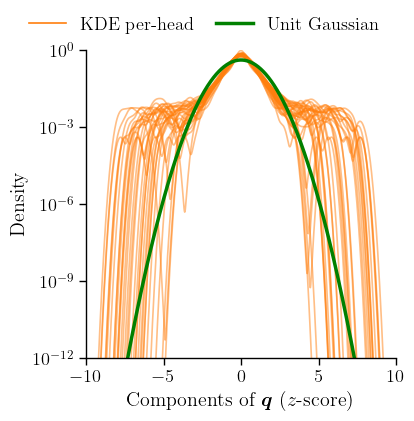

In [7]:
layer = 16

plt.figure(figsize=(4, 4))
ax = plt.gca()
min_z, max_z = -10, 10
x = np.linspace(min_z, max_z, num=1000)
for head in range(32):
    q = Q[:, layer, head, 0, :].flatten()
    z = (q - q.mean()) / q.std()
    kde = scipy.stats.gaussian_kde(z, bw_method=0.2)
    ax.plot(x, kde.pdf(x), c="C1", alpha=.5,
            label="KDE per-head" if head==0 else None)

ax.plot(x, scipy.stats.norm.pdf(x, 0, 1), lw=2.5, c="green", label="Unit Gaussian")

ax.set_yscale("log")
ax.set_ylim((10**-12, 1))
ax.set_yticks([10**n for n in [0, -3, -6, -9, -12]])
ax.set_ylabel("Density")
ax.set_xlim((min_z, max_z))
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_xlabel(r"Components of $\boldsymbol{q}$ ($z$-score)")
# ax.legend(loc="lower center", frameon=False, ncols=2, bbox_to_anchor=(0, -0.45, 1, 0))
ax.legend(loc="lower right", frameon=False, ncols=2, bbox_to_anchor=(0, 1, 1, 0),
          columnspacing=1.2)
for h in ax.legend_.legend_handles:
    h.set_alpha(1)
sns.despine(ax=ax)
plt.savefig("out/analysis/query_hist.pdf", bbox_inches="tight")

In [23]:
sns.color_palette()[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

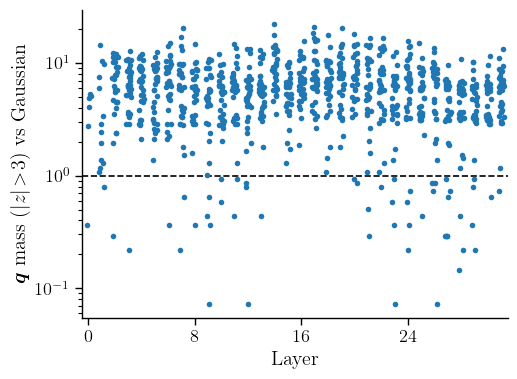

In [24]:
def show_head_stripplot(data: Tensor, color: Any) -> matplotlib.axes.Axes:
    """data -- (layer, *)"""
    plt.figure(figsize=(5.5, 4))
    ax = sns.stripplot(data.T, s=4, jitter=0.2, color=color)
    ax.set_xticks([0, 8, 16, 24])
    ax.set_yticks([0, 10, 20, 30])
    ax.set_xlabel("Layer")
    sns.despine(ax=ax)
    return ax

Qzvalues = Q - Q.mean(dim=(0, 4), keepdim=True) / Q.std(dim=(0, 4), keepdim=True)
outer_mass = (Qzvalues > 3).float().mean(dim=(0, 4)).squeeze(-1)
outer_mass_normal = 2 * (1 - scipy.stats.norm.cdf(3))
outer_mass_relative_to_normal = outer_mass.sort(dim=1).values / outer_mass_normal

ax = show_head_stripplot(outer_mass_relative_to_normal, color=sns.color_palette()[0])
ax.axhline(y=1, color="k", linestyle='--')
ax.set_ylabel(r"$\boldsymbol{q}$ mass $(|z|\!>\!3)$ vs Gaussian")
ax.set_yscale("log")
plt.savefig("out/analysis/query_z_strip.pdf", bbox_inches="tight")

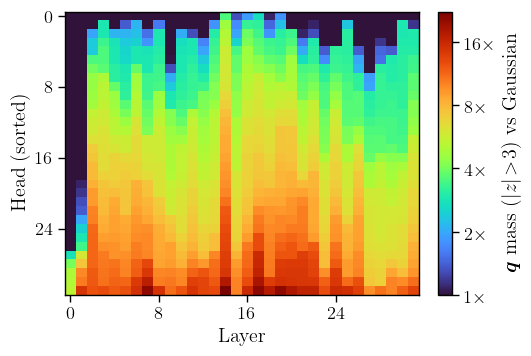

In [9]:
_, bar = show_head_heatmap(outer_mass_relative_to_normal, matplotlib.colors.SymLogNorm(linthresh=0.001, vmin=1, base=2))
bar.set_label(r"$\boldsymbol{q}$ mass $(|z|\!>\!3)$ vs Gaussian")
bar.formatter = "${x:.0f}\\times$"
bar.update_ticks()
plt.savefig("out/analysis/query_z_heatmap.pdf", bbox_inches="tight")

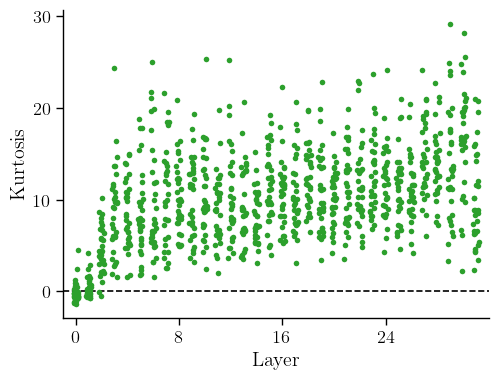

In [27]:
Qkurtosis = torch.tensor(scipy.stats.kurtosis(Q, axis=(0, 4), fisher=True, bias=True).squeeze(-1))

ax = show_head_stripplot(Qkurtosis, color=sns.color_palette()[2])
ax.set_xlim((-1, 32))
ax.axhline(y=0, color="k", linestyle='--')
ax.set_ylabel("Kurtosis")
plt.savefig("out/analysis/query_kurtosis_strip.pdf", bbox_inches="tight")

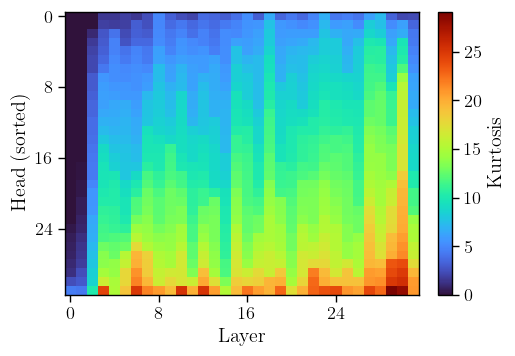

In [11]:
ax, bar = show_head_heatmap(Qkurtosis, matplotlib.colors.Normalize(vmin=0))
bar.set_label("Kurtosis")
plt.savefig("out/analysis/query_kurtosis_heatmap.pdf", bbox_inches="tight")

# Approximate score calibration

In [12]:
def approx_score(q: Tensor, k: Tensor, mask: Tensor, rank: int, method: str, norm: str) -> Tensor:
    assert q.shape[-2] == 1
    head_dim = q.shape[-1]
    if method == "random_projection":
        proj = torch.randn((1, *q[0, :, :, 0, :].shape + (rank,))) * head_dim**-0.5
        s = (q @ proj) @ (k @ proj).transpose(-1, -2)
        s /= dict(head_dim=head_dim, rank=rank, none=1)[norm] ** .5
        return s + mask

    if method == "top":
        i = torch.topk(q.abs(), k=rank, dim=-1).indices
    elif method == "first":
        i = torch.arange(rank).expand(*q.shape[:-1], rank)
    elif method == "last":
        i = torch.arange(q.shape[-1] - rank, q.shape[-1]).expand(*q.shape[:-1], rank)
    ik = i.expand(*k[..., :rank].shape)
    s = (torch.gather(q, -1, i) @ torch.gather(k, -1, ik).transpose(-1, -2))

    if norm == "coverage":
        s /= (head_dim * torch.gather(q, -1, i).abs().sum(-1, keepdim=True) / q.abs().sum(-1, keepdim=True)) ** .5
    elif norm == "coverage_L2":
        s /= (head_dim * torch.gather(q, -1, i).pow(2).sum(-1, keepdim=True) / q.pow(2).sum(-1, keepdim=True)) ** .5
    else:
        s /= dict(head_dim=head_dim, rank=rank, none=1)[norm] ** .5
    return s + mask

k, rank = 128, 32

top = torch.topk(A, k=k, dim=-1).indices
mass_a = torch.gather(A, -1, top).sum(-1).squeeze(-1)
mass_a_approx = {}
for norm in ["none", "rank", "head_dim", "coverage"]:
    approx = torch.softmax(approx_score(Q, K, M, rank=rank, method="top", norm=norm), dim=-1)
    mass_a_approx[norm] = torch.gather(approx, -1, top).sum(-1).squeeze(-1)

In [13]:
print("\\alpha RMSE:")
for norm in mass_a_approx:
    print(f"{norm:<10} {(mass_a - mass_a_approx[norm]).pow(2).mean().sqrt():.3f}")

\alpha RMSE:
none       0.135
rank       0.067
head_dim   0.046
coverage   0.037


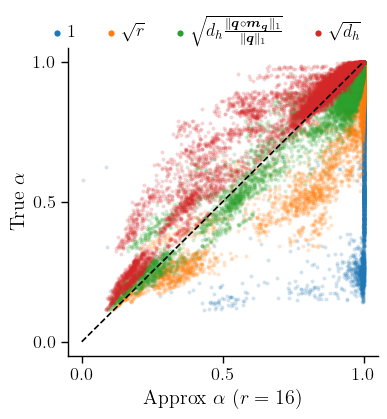

In [55]:
labels = dict(
    none="$1$",
    rank=r"$\sqrt{r}$",
    # coverage=r"$\sqrt{ d_h \frac{ \|\boldsymbol{q}[\boldsymbol{i}_1]\|_1 }{ \|\boldsymbol{q}\|_1 } }$",
    # coverage=r"$\sqrt{d_h \dfrac{\norm{\boldsymbol{q} \circ \boldsymbol{m_q}}{1}}{\norm{\boldsymbol{q}}{1}}}$",
    coverage=r"$\sqrt{d_h \frac{ \|\boldsymbol{q} \circ \boldsymbol{m_q}\|_1 }{ \|\boldsymbol{q}\|_1 }}$",
    head_dim=r"$\sqrt{d_h}$",
)

plt.figure(figsize=(4, 4))
ax = plt.gca()
for norm in labels:
    ax.scatter(mass_a_approx[norm].flatten(), mass_a.flatten(), label=labels[norm],
               alpha=.2, s=8, edgecolors=None, linewidths=0)
ax.plot([0, 1], [0, 1], "k--")
# ax.legend(title="Scale", frameon=False, bbox_to_anchor=(0.95, 0.5), loc="center left", handletextpad=0)
# ax.legend(frameon=False, bbox_to_anchor=(0, 0.95, 1, 0.1), loc="lower left", handletextpad=0, ncols=4,
#           fontsize=13, columnspacing=0)
ax.legend(frameon=False, bbox_to_anchor=(0, 0.95, 1, 0.1), loc="lower right", handletextpad=-0.4, ncols=4,
          fontsize=13, columnspacing=0.9)
# ax.legend(frameon=False, bbox_to_anchor=(0, -0.37, 1, 0.1), loc="lower right", handletextpad=-0.4, ncols=4,
#           fontsize=13, columnspacing=0.9)
ax.legend_.get_title().set_fontsize(13)
for h in ax.legend_.legend_handles:
    h.set_alpha(1)
    h.set_sizes([20])
ax.set_xlabel(f"Approx $\\alpha$ $(r={rank})$")
ax.set_ylabel(r"True $\alpha$")
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([0, 0.5, 1])
sns.despine(ax=ax)
# Note: png because there are too many points for raster
plt.savefig("out/analysis/reallocation_scale_scatter.png", bbox_inches="tight", dpi=300)

# Top-k agreement score

In [15]:
def topk_agreement(a: Tensor, b: Tensor, mask: Tensor, k: int) -> Tensor:
    ma = (a >= -torch.kthvalue(-a, k=k, keepdim=True).values)
    mb = (b >= -torch.kthvalue(-b, k=k, keepdim=True).values)
    m = mask == 0
    return (ma & mb & m).sum(-1) / torch.minimum(m.sum(-1), torch.tensor(k))

rank = 16
k = 32
aggreement_by_method = {}
for method in ["top", "first", "last", "random_projection"]:
    torch.manual_seed(248752)
    aggreement_by_method[method] = topk_agreement(A, approx_score(Q, K, M, rank=rank, method=method, norm="none"), M, k=k)

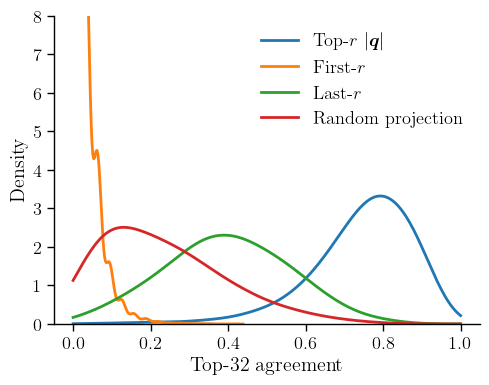

In [16]:
plt.figure(figsize=(5.5, 4))
ax = plt.gca()
labels = dict(
    top=f"Top-$r$ $|\\boldsymbol{{q}}|$",
    first=f"First-$r$",
    last=f"Last-$r$",
    random_projection="Random projection",
)
for key, agreement in aggreement_by_method.items():
    sns.kdeplot(agreement.flatten(), label=labels[key], clip=(0, 1), bw_method=0.3, ax=ax, lw=2)
ax.legend(frameon=False)
ax.set_ylim((0, 8))
ax.set_xlabel(f"Top-{k} agreement")
sns.despine(ax=ax)
plt.savefig("out/analysis/agreement_method_hist.pdf", bbox_inches="tight")

In [17]:
df = pd.DataFrame.from_dict(
    [dict(k=k, rank=rank, agreement=topk_agreement(A, approx_score(Q, K, M, rank=rank, method="top", norm="none"), M, k=k).flatten().tolist())
     for rank in [8, 16, 32, 64]
     for k in [32, 64, 128, 256]]
)

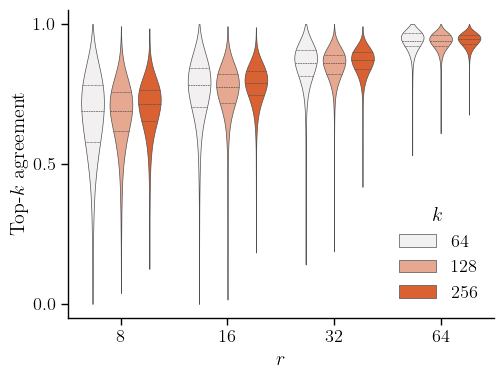

In [50]:
plt.figure(figsize=(5.5, 4))
ax = sns.violinplot(data=df[df.k >= 64].explode("agreement"), y="agreement", x="rank", hue="k", hue_norm=matplotlib.colors.LogNorm(), palette="light:#f55516",
                    linewidth=0.5, inner="quart", width=.8, gap=.2, bw_method=0.3, density_norm="width", cut=0)
ax.legend_.set_frame_on(False)
ax.legend_.set_title("$k$")
ax.set_yticks([0, 0.5, 1])
ax.set_xlabel("$r$")
ax.set_ylabel("Top-$k$ agreement")
sns.despine(ax=ax)
plt.savefig("out/analysis/agreement_rk_violin.pdf", bbox_inches="tight")

# Arithmetic intensity

In [19]:
def arithmetic_intensity(rho: float, g: float, B: int) -> float:
    return (6 * B + rho * g * B) / (6 + rho * B)

dfi = pd.DataFrame.from_dict(
    [dict(rho=rho, B=B, g=g, ai=arithmetic_intensity(rho=rho, g=g, B=B))
     for rho in 2**np.arange(-6, 6.01, 1)
     for B in (2**np.arange(0, 10.01, .25)).astype(np.int32)
     for g in [1, 8]]
)

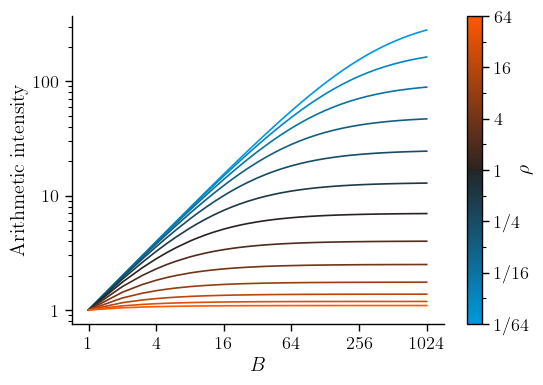

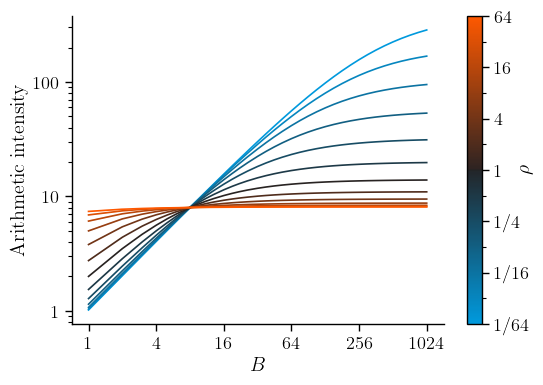

In [20]:
# matplotlib.rc("font", family="sans-serif"); matplotlib.rc("text", usetex=False)
# matplotlib.rc("font", family="serif"); matplotlib.rc("text", usetex=True)

for g, d in dfi.groupby("g"):
    plt.figure(figsize=(6, 4))
    norm = matplotlib.colors.SymLogNorm(vmin=d.rho.min(), vmax=d.rho.max(), linthresh=1e-5, base=2)
    palette = sns.diverging_palette(240, 20, s=100, l=60, center="dark", as_cmap=True)
    ax = sns.lineplot(data=d, y="ai", x="B", hue="rho", hue_norm=norm, palette=palette)
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=palette, norm=norm), ax=ax)
    cbar.set_label(r"$\rho$", labelpad=-10)
    cbar.ax.yaxis.set_major_formatter(lambda x, _: f"1/{1/x:.0f}" if x < 1 else f"{x:.0f}")
    cbar.ax.set_yticks([1/64, 1/16, 1/4, 1, 4, 16, 64])
    ax.legend_.remove()
    ax.set_xscale("log", base=2)
    ax.xaxis.set_major_formatter("{x:.0f}")
    ax.set_xticks([1, 4, 16, 64, 256, 1024])
    ax.set_yscale("log")
    ax.yaxis.set_major_formatter("{x:.0f}")
    ax.set_xlabel("$B$")
    ax.set_ylabel("Arithmetic intensity")
    sns.despine(ax=ax)
    plt.savefig(f"out/arithmetic_intensity_g{g}.pdf", bbox_inches="tight")